<a href="https://colab.research.google.com/github/dolevi101/PPKMeans/blob/main/PP_TiiKM_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [353]:
#!pip install numpy
#!pip install matplotlib
!pip install fuzzy-c-means

In [354]:
import copy
import time
import numpy as np
import math
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import itertools
import random
from fcmeans import FCM

In [355]:
def fuzzy_c_means(n_clusters, data):
    my_model = FCM(n_clusters=n_clusters,m=3)
    my_model.fit(np.transpose(data)) ## X, numpy array. rows:samples columns:features
    labels_data = [0]*data.shape[1]
    labels_centers = [1]*(my_model.centers.shape[0])
    labels = labels_data + labels_centers
    X = np.concatenate((data,my_model.centers),axis=None)
    print_fig(X, labels, "real fuzzy_c_means")
    return my_model.centers


def real_kmeans(n_clusters, data):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(np.array(data))

    labels_data = [0]*len(data)
    labels_centers = list(range(1, len(kmeans.cluster_centers_) + 1))
    X = data + list(kmeans.cluster_centers_)
    x_data = [row[0] for row in X]
    y_data = [row[1] for row in X]
    colors = labels_data + labels_centers
    print_fig(x_data, y_data, "Real kMeans", iteration=0, colors=colors, tochange=True)

    return kmeans.cluster_centers_

In [356]:
def print_fig(X, Y, plot_name, iteration=0, colors=None, tochange=None, subtitle=None,):
    # Create a scatter plot
    fig, axs = plt.subplots(nrows=1, ncols=1)
    #centers_colors = [(item+1) for item in centers_colors]
    if colors is None:
      axs.scatter(x=X, y=Y, c=Y)
    else:
      axs.scatter(x=X, y=Y, c=colors)
    if iteration==0:
      axs.set_title(plot_name)
    else:
      axs.set_title(plot_name + ": iteration={}".format(iteration))
    if tochange is None:
      axs.set_ylim(-1, 6)
      axs.set_xlim(0, 1)
      fig.set_figheight(1.5)
    else:
      axs.set_ylim(0, 1)
      axs.set_xlim(0, 1)
    fig.show()

In [357]:
def distance_2d(a, b):
  #pitagors without the square root
  return ((a[0]-b[0]) ** 2) + ((a[1]-b[1]) ** 2)
  #return math.dist(a, b)


#efficient powering, takes log(p) calculations
def power(base, exponent):
    result = 1
    if exponent < 0:
        base = 1 / base
        exponent = -exponent
    while exponent > 0:
        if exponent % 2 == 1:
            result *= base
        base *= base
        exponent //= 2
    return result


def get_normalized_sum_distance_p(sum_distance_p, p, n, num_of_points = 1):
  normalize_factor = (1 / (power(2, p) * num_of_points) )
  normalized_sum_distance_p = sum_distance_p * normalize_factor
  normalized_approx = inverse(normalized_sum_distance_p, n)
  approx = normalized_approx * normalize_factor
  return approx


#def get_p_value(dis_p, sum_distance_p, p, n, num_of_points = 1):
  #normalize_factor = (1 / (power(math.sqrt(2), p) * num_of_points) )
  #normalize_factor = (1 / (power(2, p) * num_of_points) )
  #normalized_sum_distance_p = sum_distance_p * normalize_factor
  #normalized_approx = inverse(normalized_sum_distance_p, n)
  #approx = normalized_approx * normalize_factor

def get_p_value(dis_p, approx):
  prob = dis_p * approx
  return prob


def inverse(x, n):
    #return 1/x
    #print("inverse({}, {})".format(x,n))
    a = 2 - x
    b = 1 - x
    for i in range(n):
        b = b ** 2
        a = a * (1 + b)
    return a

In [358]:
def prob_to_be_in_center_2d(data, centers, p,n):
  num_of_centers = len(centers)
  num_of_points = len(data)
  #distances = []
  distances_p = []
  sum_distance_p_from_centers = []
  for c in centers:
      dises = []
      for x in data:
            dis = distance_2d(x, c)
            dises.append(dis)
            #dises.append(dis**p)
            #dises.append(power(dis, p))

      #all_dis_per_center = [(max(dises) - item + 0.05) for item in dises]
      all_dis_per_center = [(math.sqrt(2) - item + 0.05) for item in dises]

      all_dis_p_per_center = []
      sum_distance_p_from_single_center = 0
      for item in all_dis_per_center:
        powered_item = power(item, p)
        all_dis_p_per_center.append(powered_item)
        sum_distance_p_from_single_center += powered_item

      #distances.append(all_dis_per_center)
      distances_p.append(all_dis_p_per_center)
      sum_distance_p_from_centers.append(sum_distance_p_from_single_center)


  probs = []
  p_values_sum = []

  for i in range(num_of_centers):
    probs_sum = [0, 0]
    p_values_sum_per_center = 0
    approx = get_normalized_sum_distance_p(sum_distance_p_from_centers[i], p, n, num_of_points)
    for j in range(num_of_points):
        p_value = get_p_value(distances_p[i][j], approx)
        #print("p_value: ", p_value)
        temp_point_contrib = [item * p_value for item in data[j]]
        probs_sum = [x + y for x, y in zip(probs_sum, temp_point_contrib)]
        p_values_sum_per_center += p_value
    probs.append(probs_sum)
    p_values_sum.append(p_values_sum_per_center)

  return probs, p_values_sum

In [359]:
def run_one_mean_2d(data, n, p, iterations, to_print, to_draw, to_draw_milestones):
    #generate random center
    centers = [[random.uniform(0, 1), random.uniform(0, 1)]]

    #plot the start position
    if to_draw_milestones:
      labels_data = [0]*len(data)
      labels_centers = list(range(1, len(centers) + 1))
      X = data + centers
      x_data = [row[0] for row in X]
      y_data = [row[1] for row in X]
      colors = labels_data + labels_centers
      print_fig(x_data, y_data, "Our kMeans 2D: Start Position", iteration=0, colors=colors, tochange=True)

    #first iteration
    start = time.time()
    probs, p_values_sum = prob_to_be_in_center_2d(data, centers, p, n)
    new_centers = [[(item/p_values_sum[c_index]) for item in probs[c_index]] for c_index in range(len(centers))]
    end = time.time()

    if to_print:
      print("({}/{}) centers = {}, Duration: {} seconds".format(1, iterations, new_centers, end - start))
    for i in range(1, iterations):
        start = time.time()
        probs, p_values_sum = prob_to_be_in_center_2d(data, new_centers,p,n)
        new_centers = [[(item/p_values_sum[c_index]) for item in probs[c_index]] for c_index in range(len(centers))]

        end = time.time()
        if to_print:
          print("({}/{}) centers = {}, Duration: {} seconds".format(i+1, iterations, new_centers, end - start))
        if to_draw:
          labels_data = [0]*len(data)
          labels_centers = list(range(1, len(new_centers) + 1))
          X = data + new_centers
          x_data = [row[0] for row in X]
          y_data = [row[1] for row in X]
          colors = labels_data + labels_centers
          print_fig(x_data, y_data, "Our kMeans 2D", iteration=i, colors=colors, tochange=True)

    #plot the final position
    if to_draw_milestones:
      labels_data = [0]*len(data)
      labels_centers = list(range(1, len(new_centers) + 1))
      X = data + new_centers
      x_data = [row[0] for row in X]
      y_data = [row[1] for row in X]
      colors = labels_data + labels_centers
      print_fig(x_data, y_data, "Our kMeans 2D: Final Position", iteration=0, colors=colors, tochange=True)

    return new_centers[0]

In [360]:
def is_new_center_2d(temp_center, known_centers, known_intervals):
  for center_index in range(len(known_centers)):
    checked_center_location = known_centers[center_index]
    checked_center_interval = known_intervals[center_index]

    temp_center_x = temp_center[0]
    temp_center_y = temp_center[1]

    checked_center_x = checked_center_location[0]
    checked_center_y = checked_center_location[1]

    temp_calc = (temp_center_x - checked_center_x) ** 2 + (temp_center_y - checked_center_y) ** 2
    #(x - center_x)² + (y - center_y)² < radius²

    if temp_calc <= checked_center_interval ** 2:
      return (False, checked_center_location, checked_center_interval)
  return (True, -1, -1)

In [361]:
def new_kmeans_2d(data, k, n, p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones = False):
  final_centers = []
  final_intervals = []
  original_data = data.copy()
  data = data.copy()
  #calculating center number i from total k
  for current_center_index in range(k):
    current_interval = interval

    for i in range(iterations_for_center):
      if len(data) == 0:
        break
      temp_center = run_one_mean_2d(data, n, p, internal_iterations, to_print, to_draw, to_draw_milestones)

      check_if_new_center = is_new_center_2d(temp_center, final_centers, final_intervals)
      is_search_stopped = check_if_new_center[0]
      prev_center = check_if_new_center[1]
      prev_interval = check_if_new_center[2]
      if is_search_stopped:
        # the new center is far from the previous centers
        # meaning we have found a new center, save it
        # move to the next one
        final_centers.append(temp_center)
        final_intervals.append(current_interval)
        data = remove_data_around_center(data, temp_center, current_interval)

        if to_draw_milestones:
          labels_data = [0]*len(original_data)
          labels_centers = list(range(1, len(final_centers) + 1))
          X = original_data + final_centers
          x_data = [row[0] for row in X]
          y_data = [row[1] for row in X]
          colors = labels_data + labels_centers
          print_fig(x_data, y_data, "Our kMeans 2D: Found {} Centers so far:\n{}".format(len(final_centers),final_centers), iteration=0, colors=colors, tochange=True)

        break

      # we got to an existing cluster which already has a center
      # so we would like to start searching again
      # remove data around previous center and double the previous interval

      data = remove_data_around_center(data, prev_center, 2 * prev_interval)
      #todo, update the known interval for previous center

  labels_data = [0]*len(original_data)
  labels_centers = list(range(1, len(final_centers) + 1))
  X = original_data + final_centers
  x_data = [row[0] for row in X]
  y_data = [row[1] for row in X]
  colors = labels_data + labels_centers
  print_fig(x_data, y_data, "Our kMeans 2D: TADAM", iteration=0, colors=colors, tochange=True)

  return final_centers

In [362]:
def remove_data_around_center(data, center, interval):
  updated_data = []

  for point in data:
    point_x = point[0]
    point_y = point[1]

    center_x = center[0]
    center_y = center[1]

    #(x - center_x)² + (y - center_y)² < radius²
    temp_calc = (point_x - center_x) ** 2 + (point_y - center_y) ** 2

    if temp_calc > interval ** 2:
      updated_data.append(point)

  return updated_data

In [363]:
def old_data_generation():
  data = []
  data.extend([[x/100,0.13] for x in list(range(10,18))])
  data.extend([[x/100,0.18] for x in list(range(10,18))])
  data.extend([[x/100,0.23] for x in list(range(10,18))])

  data.extend([[x/100,0.75] for x in list(range(30,40))])
  data.extend([[x/100,0.8] for x in list(range(30,40))])
  data.extend([[x/100,0.85] for x in list(range(30,40))])

  data.extend([[x/100,0.45] for x in list(range(70,80))])
  data.extend([[x/100,0.5] for x in list(range(70,80))])
  data.extend([[x/100,0.55] for x in list(range(70,80))])

  return data

In [364]:
a = [[1,2], [2,3]]
a.append([4,5])
b = [[1,2], [2,3]]
a = a + b
a

[[1, 2], [2, 3], [4, 5], [1, 2], [2, 3]]

In [365]:
def generate_data_points(center, radius, num_points):
    data_points = []
    cx, cy = center

    for _ in range(num_points):
        angle = random.uniform(0, 2 * math.pi)
        distance = random.uniform(0, radius)
        x = cx + distance * math.cos(angle)
        y = cy + distance * math.sin(angle)
        if 0 < x < 1 and 0 < y < 1:
          data_points.append([x, y])

    return data_points


def generate_data_circles(k, radius_range=[0.05, 0.2], num_points_range=[10,50]):
  generated_data = []

  for i in range(k):
    center = [random.uniform(0, 1), random.uniform(0, 1)]
    radius = random.uniform(radius_range[0], radius_range[1])
    num_points = random.randint(num_points_range[0],num_points_range[1])
    generated_data += generate_data_points(center, radius, num_points)

  return generated_data


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([[0.20881906, 0.75211908],
       [0.71816913, 0.14026982],
       [0.81978773, 0.84414652]])

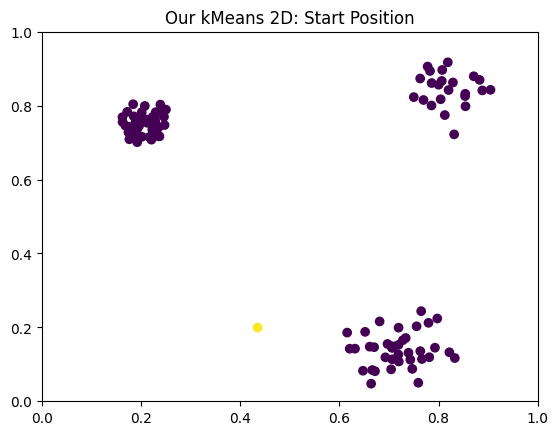

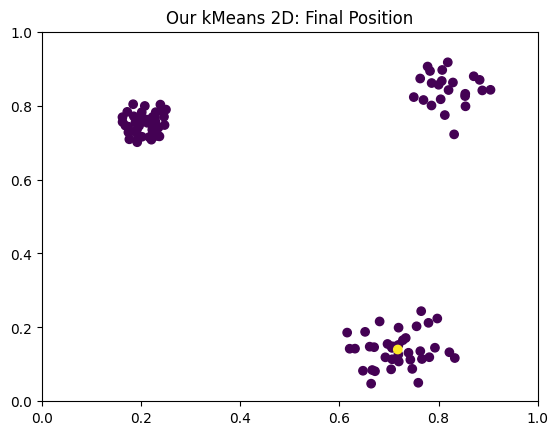

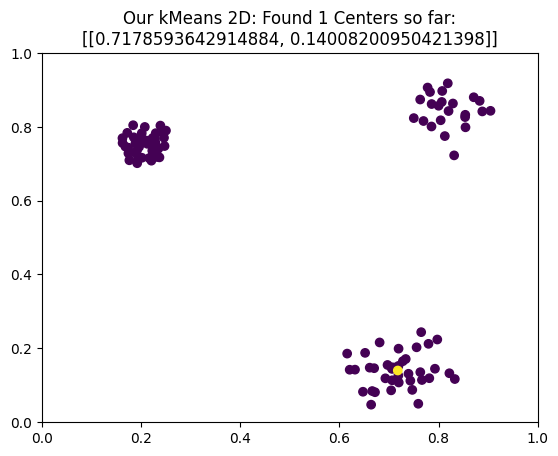

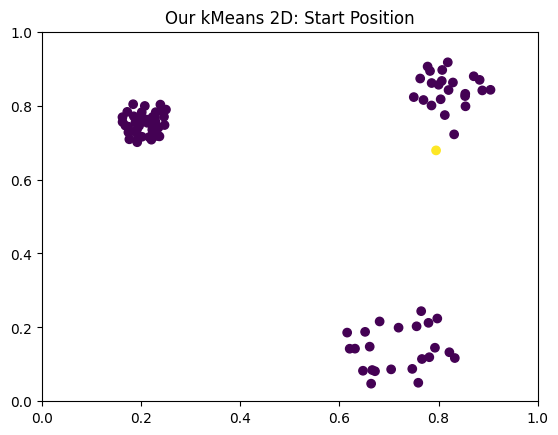

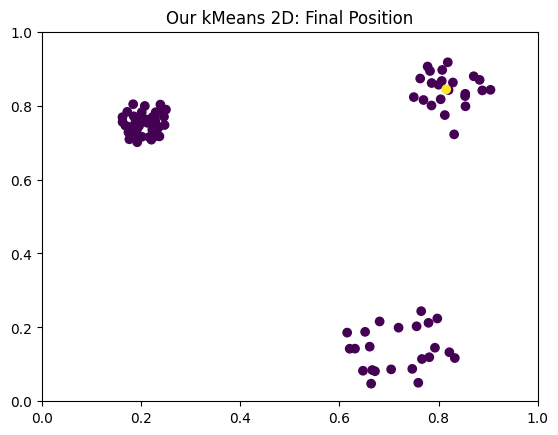

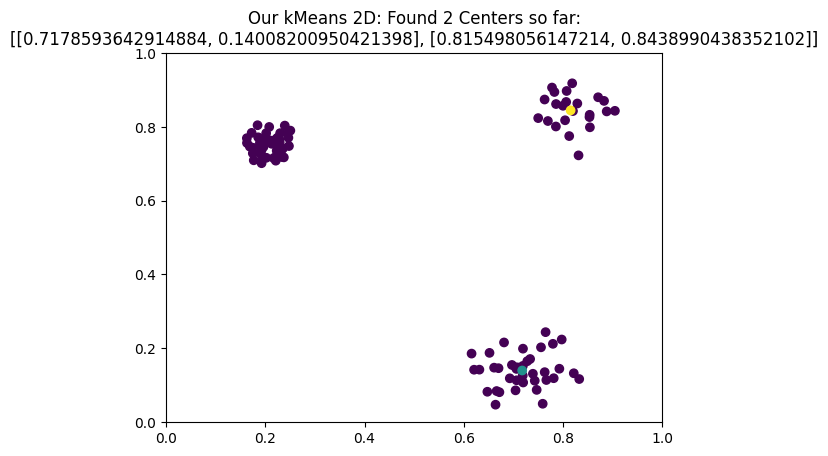

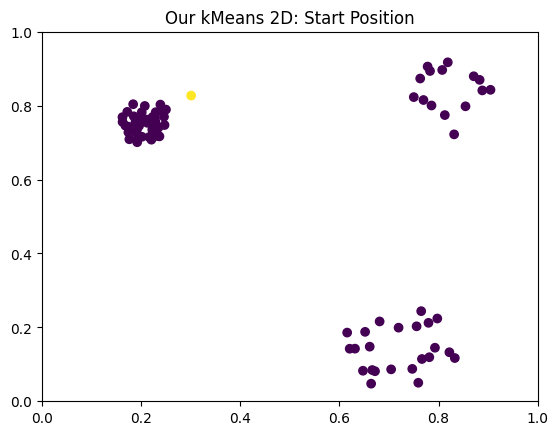

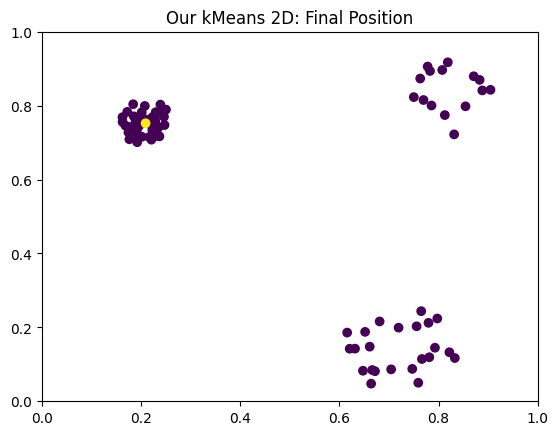

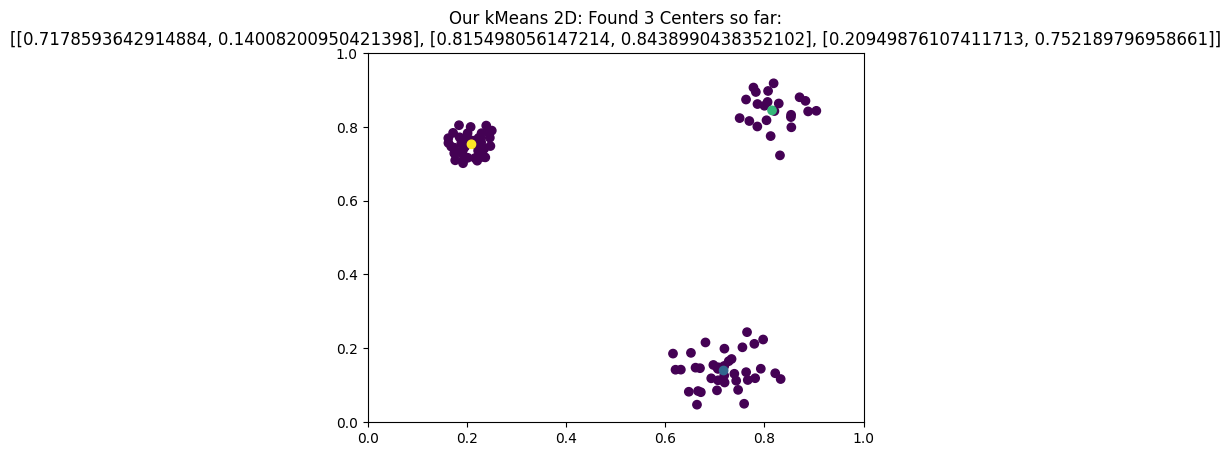

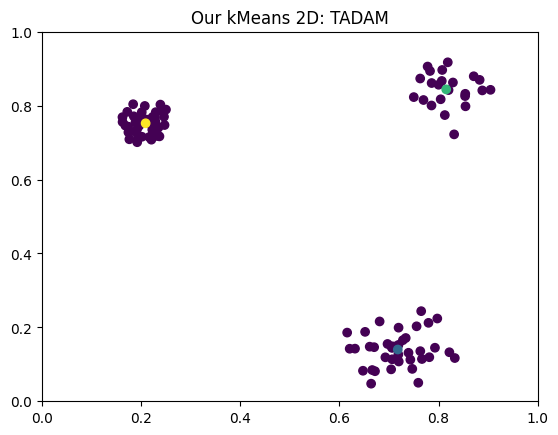

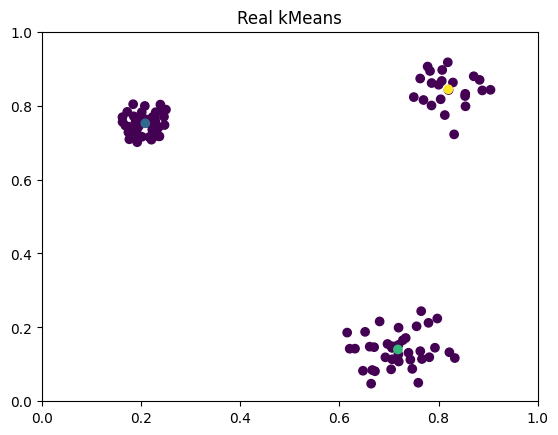

In [366]:
#variables
k = 3
n = 3
p = 20
iterations_for_center = 10
internal_iterations = 20
interval = 0.05
to_print = False
to_draw = False
to_draw_milestones = True


#Data Generation
data = generate_data_circles(k)


discovered_centers = new_kmeans_2d(data, k, n, p, iterations_for_center, internal_iterations, interval, to_print, to_draw, to_draw_milestones)
#suggestion, run the same algorithm, but now data=discovered_centers

#fuzzy_c_means(k, (np.asarray(data)).reshape(1,-1))
#real_kmeans(k, data)

#TODO: intersection overlapping interval
#todo, update the known interval for previous center in new_kmeans_2d to be doubled
#todo: calculate sum_distance_p approx in inverse outside the function, no need to do it each time